In [24]:
%cd "C:/app"

C:\app


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


sns.set(rc={'figure.figsize':(10,5)})
sns.set_theme()
sns.set_style('whitegrid')

In [26]:
from pathlib import Path

from scipy.stats import spearmanr

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, _tree
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, make_scorer
from sklearn.preprocessing import scale

import graphviz

In [27]:
from sklearn.preprocessing import scale
# load data

data = pd.read_csv("./data/trees/features_targets.csv", index_col="Timestamp", parse_dates=["Timestamp"])
# data = data.head(1000)
data


excluded_cols = ['Open',
 'High',
 'Low',
 'Close',
 'Symbol']

all_cols = [c for c in data.columns if c not in excluded_cols ]
data = data[all_cols]

data.loc[:, data.columns] = scale(data)

features_cols = data.columns[data.columns.str.contains("TARGET") == False]
features = data[features_cols]
features.describe()

target_col = "TARGET_LOGRET_5"
targets = data[[target_col]]
targets.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13906 entries, 2018-01-26 15:00:00 to 2019-12-31 15:30:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TARGET_LOGRET_5  13906 non-null  float64
dtypes: float64(1)
memory usage: 217.3 KB


In [28]:
# select two features for the rest
selected_features = ["STDEV_100", "SMA_500"]
X_2 = features[selected_features]
y_2 = targets

<Axes: ylabel='Density'>

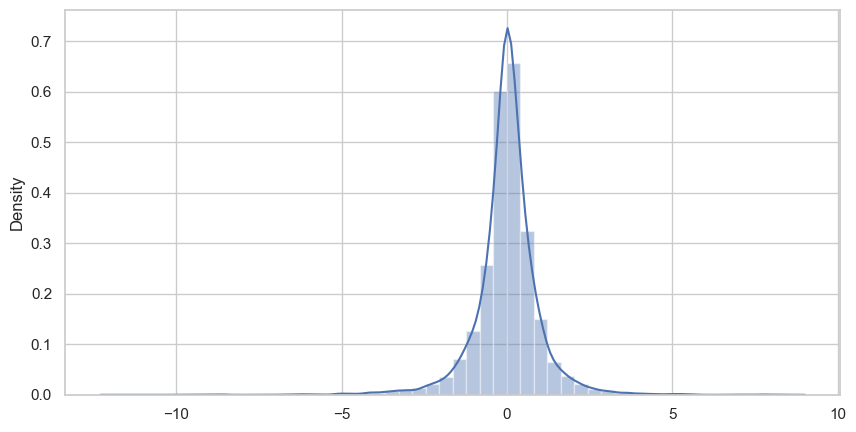

In [29]:
# Explore data
sns.distplot(y_2)

In [30]:
# configure tree
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

from sklearn.tree import DecisionTreeRegressor, export_graphviz

tree_reg = DecisionTreeRegressor(criterion='squared_error',
                                    max_depth=6,
                                    min_samples_split=2,
                                    min_samples_leaf=50,
                                   )


**Train Decision Tree**

In [31]:
# %%timeit
tree_reg.fit(X=X_2,y=y_2)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=50)

**Visualize Tree**

In [32]:
import graphviz
from sklearn import tree

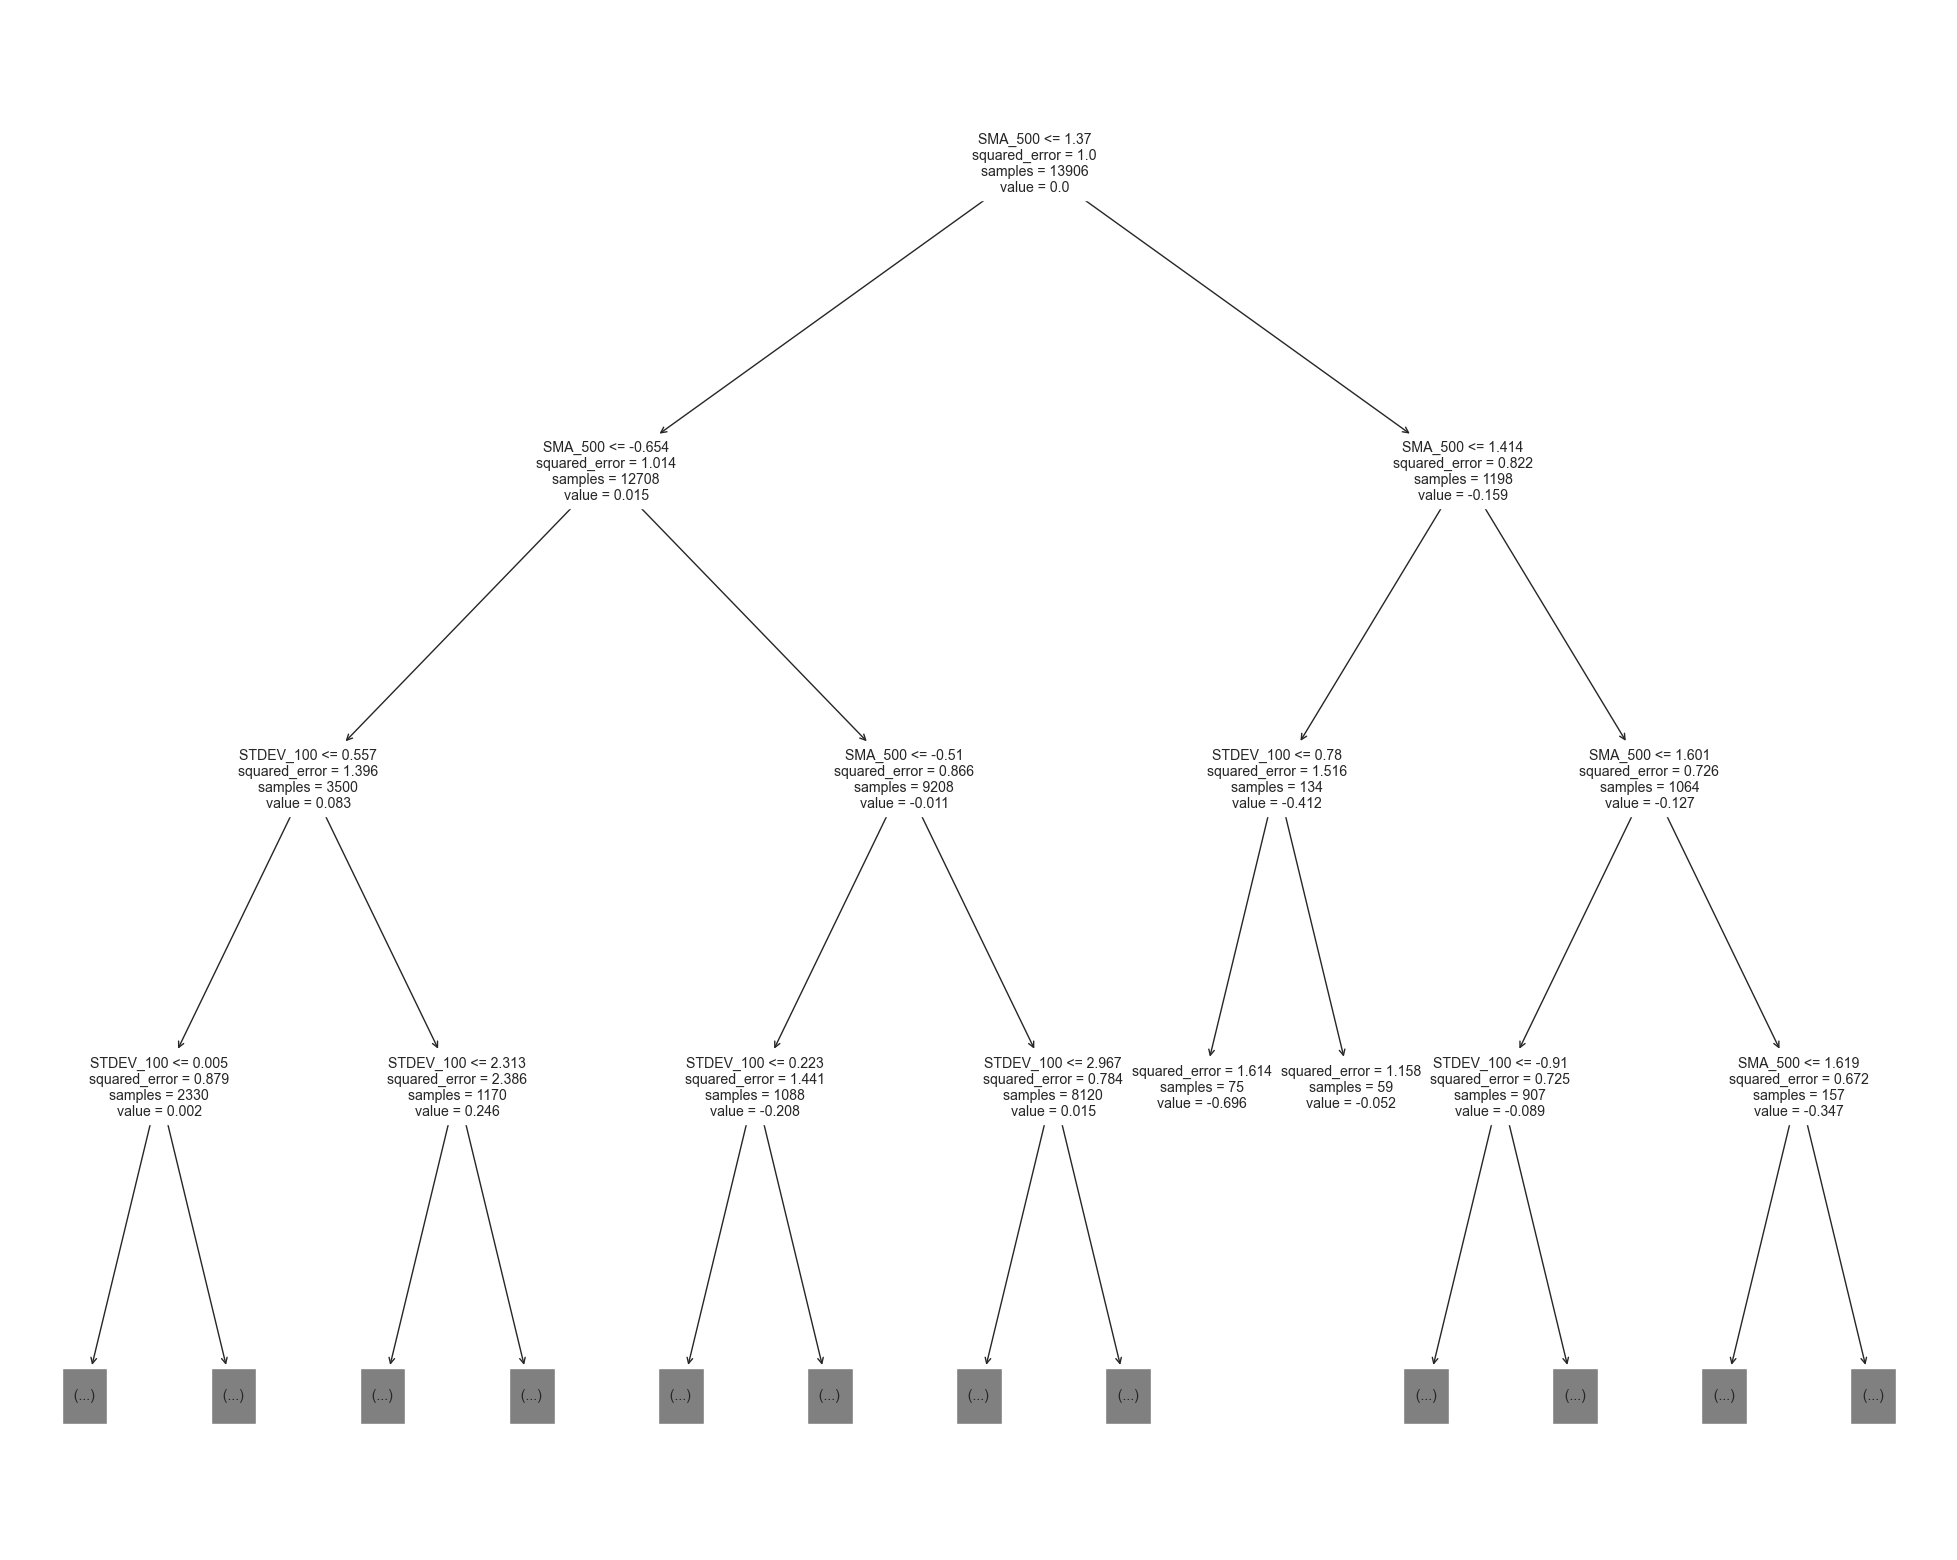

In [33]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree_reg,
                    max_depth=3,
                    feature_names=list(X_2.columns))

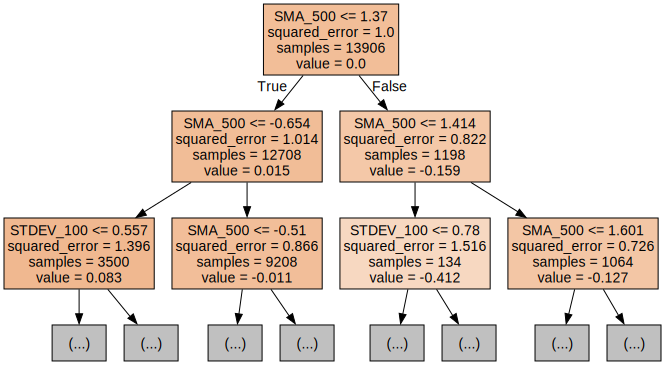

In [34]:
dot_data = export_graphviz(tree_reg,
                          feature_names=X_2.columns,
                          class_names = y_2.columns,
                          max_depth=2,
                          filled=True,
                          )
graphviz.Source(dot_data)

**Linear Regression vs Regression Tree Decision Surfaces**

In [35]:
from sklearn.metrics import mean_squared_error
y_preds = tree_reg.predict(X_2)
error = mean_squared_error(y_2, y_preds)
error

0.942167611057394

<Axes: xlabel='STDEV_100', ylabel='SMA_500'>

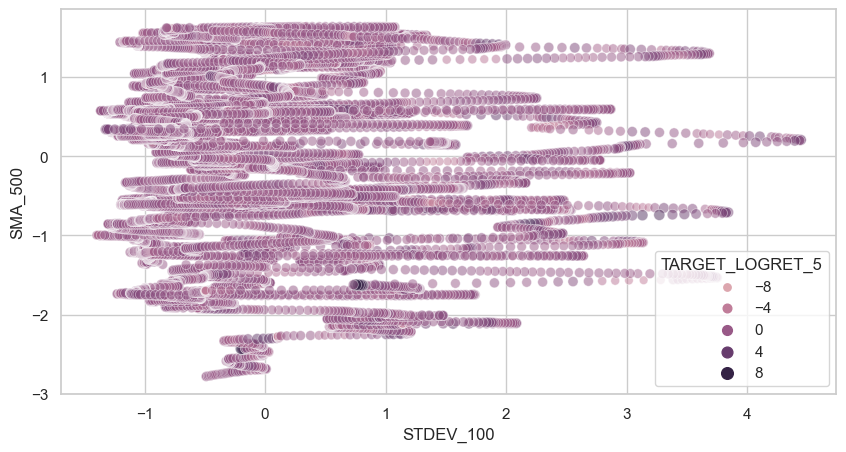

In [36]:
df = X_2.join(y_2)

sns.scatterplot(x="STDEV_100", y="SMA_500", 
                size="TARGET_LOGRET_5", 
                hue="TARGET_LOGRET_5", 
                data=df,
                alpha=0.5
               )

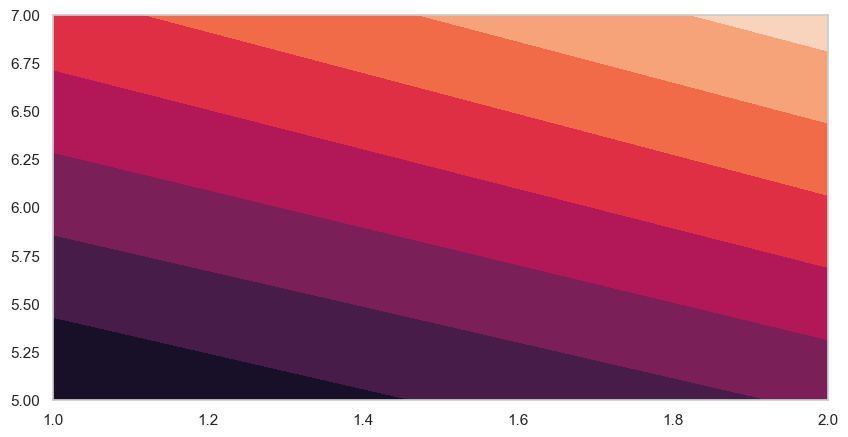

In [37]:
# simple meshgrid
xv, yv = np.meshgrid([1,2], [5,7])
x_space = np.c_[xv.ravel(), yv.ravel()]
y_vals = np.square(xv+yv).reshape(xv.shape)
plt.contourf(xv, yv, y_vals)

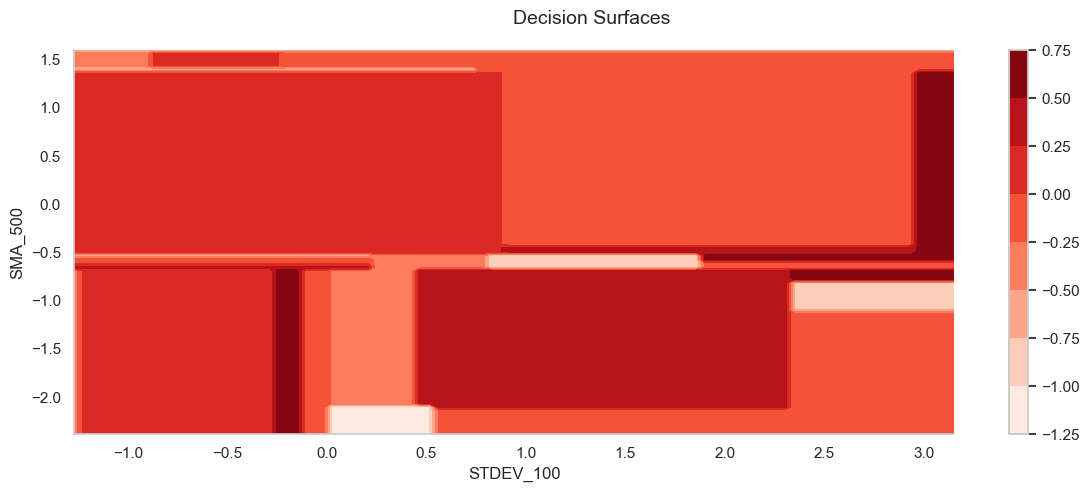

In [38]:
# decision surface for two features
fs = selected_features
t1, t2 = np.meshgrid(np.linspace(X_2[fs[0]].quantile(.01), X_2[fs[0]].quantile(.99), 100),
                     np.linspace(X_2[fs[1]].quantile(.01), X_2[fs[1]].quantile(.99), 100))
X_data = np.c_[t1.ravel(), t2.ravel()]


fig, axes = plt.subplots(ncols=1, figsize=(12,5))



# Regression Tree
ret2 = tree_reg.predict(X_data).reshape(t1.shape)
surface2 = axes.contourf(t1, t2, ret2, cmap='Reds')
plt.colorbar(mappable=surface2, ax=axes)

# Format plots
axes.set_xlabel(fs[0])
axes.set_ylabel(fs[1])

fig.suptitle('Decision Surfaces', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);

**Regression Tree with all Features**

In [39]:
X = pd.get_dummies(features)
y = targets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
regression_tree = DecisionTreeRegressor(criterion='squared_error',
                                        splitter='best',
                                        max_depth=5,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_features=None,
                                        random_state=42,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                       )

In [41]:
regression_tree.fit(X=X_train, y=y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

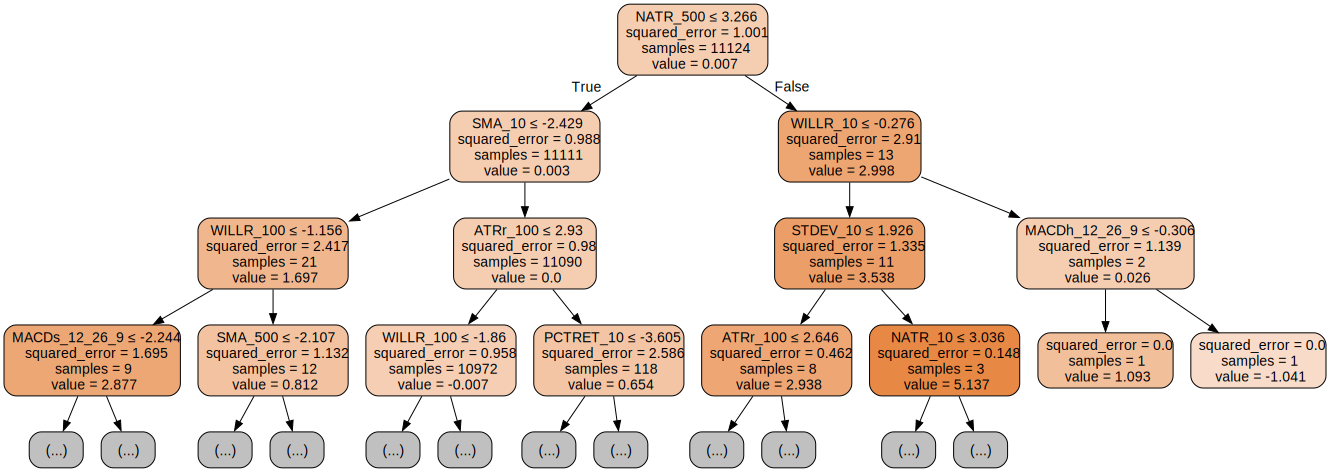

In [42]:
dot_data = export_graphviz(regression_tree,
                           feature_names=X_train.columns,
                           max_depth=3,
                           filled=True,
                           rounded=True,
                           special_characters=True)

graphviz.Source(dot_data)

In [43]:
# measure prediction
y_pred = regression_tree.predict(X_test)
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))

1.0095195754930815

In [44]:
r, p = spearmanr(y_pred, y_test)
print(f'{r*100:.2f} (p-value={p:.2%})')

4.71 (p-value=1.29%)
